#  DS MARKET MODELOS

In [ ]:
import joblib
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')


# Montando Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importando df's encoded

In [ ]:
df_final = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/NOVOS DF/df_final_enc.csv")

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/NOVOS DF/test_enc.csv")

# Preparação de Dados para Validação e Teste em Séries Temporais

In [ ]:
# Carregar os mapeamentos
d_store_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_store_id.pkl')
d_state_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_state_id.pkl')
d_department_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_dept_id.pkl')

output_path = '/content/drive/MyDrive/ARQUIVOS TFM/Modelos/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

divisions = ['store', 'department']
division_names = {'store': 'Store', 'department': 'Department'}
division_id_maps = {'store': d_store_id, 'department': d_department_id}

results = []

for division in divisions:
    unique_values = df_final[division].unique().tolist()

    for value_code in tqdm(unique_values):
        value_name = division_id_maps[division][value_code]
        region = d_state_id[df_final[df_final['store'] == value_code]['region'].iloc[0]] if division == 'store' else None

        df_division = df_final[df_final[division] == value_code].drop(['date'], axis=1)

        X = df_division.drop('sold_units', axis=1)
        y = df_division['sold_units']

        mae_fold = []
        r2_fold = []
        rmse_fold = []

        best_rmse = float('inf')  # inicializa com infinito
        best_model = None

        for train_idx, valid_idx in kf.split(X, y):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

            model = LGBMRegressor(
                n_estimators=1000,
                learning_rate=0.3,
                subsample=0.8,
                colsample_bytree=0.8,
                max_depth=8,
                num_leaves=50,
                min_child_weight=300,
                force_row_wise=True,
                verbose=-1
            )

            print('*****Prediction for {}: {}*****'.format(division_names[division], value_name))

            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='rmse')
            y_pred = model.predict(X_valid)

            current_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_model = model

            mae_fold.append(mean_absolute_error(y_valid, y_pred))
            r2_fold.append(r2_score(y_valid, y_pred))
            rmse_fold.append(current_rmse)

        # Salva apenas o melhor modelo
        filename = os.path.join(output_path, f'best_model_{division}_{value_name}.pkl')
        joblib.dump(best_model, filename)

        result = {
            division_names[division]: value_name,
            'Region': region,
            'MAE': np.mean(mae_fold),
            'R2': np.mean(r2_fold),
            'RMSE': np.mean(rmse_fold)
        }

        results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: South_End*****
*****Prediction for Store: South_End*****
*****Prediction for Store: South_End*****
*****Prediction for Stor

  0%|          | 0/7 [00:00<?, ?it/s]

*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_2*****
*****Prediction for Department: HOME_&_GARDEN_2*****
*****Prediction for Department: HOME_&_GARDEN_2*****
*****Prediction for Department: HOME_&_GARDEN_2*****
*****Prediction for Dep

In [ ]:
results_df

,Store,Region,MAE,R2,RMSE,Department
0,Greenwich_Village,New York,0.063371,0.974816,0.640988,NaN
1,Harlem,New York,0.033414,0.990559,0.266602,NaN
2,Tribeca,New York,0.100067,0.976265,0.958235,NaN
3,Brooklyn,New York,0.021985,0.987286,0.222795,NaN
4,South_End,Boston,0.044849,0.972855,0.547472,NaN
5,Roxbury,Boston,0.055082,0.982658,0.584417,NaN
6,Back_Bay,Boston,0.046373,0.980460,0.530668,NaN
7,Midtown_Village,Philadelphia,0.024306,0.992375,0.210667,NaN
8,Yorktown,Philadelphia,0.037126,0.992304,0.338564,NaN
9,Queen_Village,Philadelphia,0.050654,0.983163,0.523962,NaN


In [ ]:
# Salva o DataFrame como um arquivo CSV no Google Drive
df_final.to_csv("/content/drive/MyDrive/ARQUIVOS TFM/NOVOS DF/df_final_enc.csv", index=False)

## Plotting feature importances

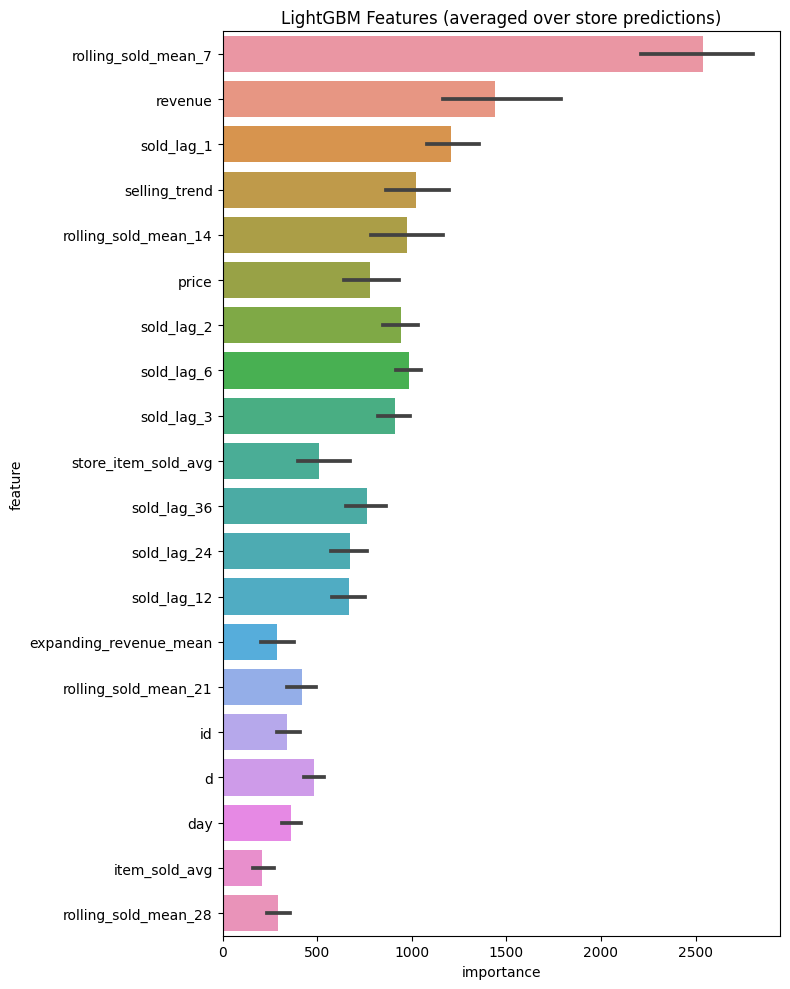

In [ ]:


# Caminho para o diretório dos modelos
model_directory = "/content/drive/MyDrive/ARQUIVOS TFM/Modelos"

# DataFrame para armazenar a importância das características
feature_importance_df = pd.DataFrame()

# Lista de características (sem a coluna target 'sold_units' e 'date')
features = [f for f in df_final.columns if f not in ['sold_units', 'date']]

# Para cada arquivo no diretório dos modelos
for filename in os.listdir(model_directory):
    if 'model_store_' in filename:
        # Caminho completo para o arquivo do modelo
        model_path = os.path.join(model_directory, filename)

        # Carregar o modelo
        model = joblib.load(model_path)

        # Extrair o nome da loja do nome do arquivo
        store_name = filename.split('_')[2]

        # Criar DataFrame para armazenar a importância das características deste modelo
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = store_name

        # Concatenar com o DataFrame principal
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

# Função para exibir as características mais importantes
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()

# Chamar função para mostrar o gráfico
display_importances(feature_importance_df)


In [ ]:
import joblib
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm  # Modificação aqui
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd
import warnings
import os

# Carregar os mapeamentos
d_store_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/mapeamento_lojas_test/d_store_id.pkl')
d_department_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/mapeamento_lojas_test/d_dept_id.pkl')

output_path = '/content/drive/MyDrive/ARQUIVOS TFM/Modelos/'

divisions = ['store', 'department']
division_names = {'store': 'Store', 'department': 'Department'}
division_id_maps = {'store': d_store_id, 'department': d_department_id}

test_results = []

for division in divisions:
    unique_values = test[division].unique().tolist()

    for value_code in tqdm(unique_values):
        value_name = division_id_maps[division][value_code]

        df_test_division = test[test[division] == value_code].drop(['date'], axis=1)

        X_test = df_test_division.drop('sold_units', axis=1)
        y_test = df_test_division['sold_units']

        # Carregar o modelo treinado
        model_filename = os.path.join(output_path, f'best_model_{division}_{value_name}.pkl')
        loaded_model = joblib.load(model_filename)

        # Fazer previsões
        y_pred = loaded_model.predict(X_test)

        # Calculando métricas de avaliação
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        result = {
            division_names[division]: value_name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse
        }

        test_results.append(result)

test_results_df = pd.DataFrame(test_results)
print(test_results_df)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

                Store       MAE        R2      RMSE       Department
0   Greenwich_Village  0.078575  0.990361  0.340967              NaN
1              Harlem  0.077275  0.981523  0.418990              NaN
2             Tribeca  0.116118  0.985211  0.610474              NaN
3            Brooklyn  0.031887  0.990642  0.182215              NaN
4           South_End  0.056478  0.986005  0.362765              NaN
5             Roxbury  0.066198  0.988868  0.374152              NaN
6            Back_Bay  0.060464  0.985733  0.393595              NaN
7     Midtown_Village  0.055099  0.981426  0.344455              NaN
8            Yorktown  0.108375  0.977937  0.725880              NaN
9       Queen_Village  0.078382  0.983795  0.487264              NaN
10                NaN  0.032575  0.985948  0.274856     ACCESORIES_1
11                NaN  0.010619  0.986433  0.092536     ACCESORIES_2
12                NaN  0.054973  0.991420  0.260687  HOME_&_GARDEN_1
13                NaN  0.011660  0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# 1. Filtrar os dados da loja de interesse no dataframe `test` e decodificar o item ID
item_map = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/mapeamento_lojas_test/d_item_id.pkl')
decoded_item_id = [key for key, value in item_map.items() if value == 'SUPERMARKET_3_090'][0]
subset_test = test[test['id'] == decoded_item_id].sort_values(by='date').copy()

# 2. Carregar o modelo treinado para a loja "Harlem"
model_path = "/content/drive/MyDrive/ARQUIVOS TFM/Modelos/best_model_store_Harlem.pkl"
loaded_model = joblib.load(model_path)

# 3. Fazer previsões com o modelo carregado
X_test_item = subset_test.drop(columns=['date', 'sold_units'])
subset_test['predicted_sales'] = loaded_model.predict(X_test_item)

# 4. Plotar o gráfico
plt.figure(figsize=(10,10))
plt.plot(subset_test['date'], subset_test['sold_units'], label='Actual Values', marker='o')
plt.plot(subset_test['date'], subset_test['predicted_sales'], label='Predicted Sales', marker='x')
plt.title(f"Actual Vs Predicted Sales of {decoded_item_id} by LGBM")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
import joblib
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd
import warnings
import os

warnings.filterwarnings('ignore')

# Carregar os mapeamentos
d_store_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_store_id.pkl')
d_state_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_state_id.pkl')
d_department_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_dept_id.pkl')

output_path = '/content/drive/MyDrive/ARQUIVOS TFM/Modelos/Modelos_final'
if not os.path.exists(output_path):
    os.makedirs(output_path)

divisions = ['store', 'department']
division_names = {'store': 'Store', 'department': 'Department'}
division_id_maps = {'store': d_store_id, 'department': d_department_id}

results = []

for division in divisions:
    unique_values = df_final[division].unique().tolist()

    for value_code in tqdm(unique_values):
        value_name = division_id_maps[division][value_code]
        region = d_state_id[df_final[df_final['store'] == value_code]['region'].iloc[0]] if division == 'store' else None

        df_train = df_final[df_final[division] == value_code].drop(['date'], axis=1)
        df_valid = test[test[division] == value_code].drop(['date'], axis=1)

        X_train = df_train.drop('sold_units', axis=1)
        y_train = df_train['sold_units']

        X_valid = df_valid.drop('sold_units', axis=1)
        y_valid = df_valid['sold_units']

        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300,
            force_row_wise=True,
            verbose=-1
        )

        print('*****Prediction for {}: {}*****'.format(division_names[division], value_name))

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='rmse')
        y_pred = model.predict(X_valid)

        mae = mean_absolute_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        # Salva o modelo
        filename = os.path.join(output_path, f'model_{division}_{value_name}.pkl')
        joblib.dump(model, filename)

        result = {
            division_names[division]: value_name,
            'Region': region,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse
        }

        results.append(result)

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
# Carregar os mapeamentos
d_store_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_store_id.pkl')
d_state_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_state_id.pkl')
d_department_id = joblib.load('/content/drive/MyDrive/ARQUIVOS TFM/mapeamento_lojas/d_dept_id.pkl')

output_path = '/content/drive/MyDrive/ARQUIVOS TFM/Modelos/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

divisions = ['store', 'department']
division_names = {'store': 'Store', 'department': 'Department'}
division_id_maps = {'store': d_store_id, 'department': d_department_id}

results = []

for division in divisions:
    unique_values = df_final[division].unique().tolist()

    for value_code in tqdm(unique_values):
        value_name = division_id_maps[division][value_code]
        region = d_state_id[df_final[df_final['store'] == value_code]['region'].iloc[0]] if division == 'store' else None

        df_train = df_final[df_final[division] == value_code].drop(['date'], axis=1)
        df_valid = test[test[division] == value_code].drop(['date'], axis=1)

        X_train = df_train.drop('sold_units', axis=1)
        y_train = df_train['sold_units']

        X_valid = df_valid.drop('sold_units', axis=1)
        y_valid = df_valid['sold_units']

        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300,
            force_row_wise=True,
            verbose=-1
        )

        print('*****Prediction for {}: {}*****'.format(division_names[division], value_name))

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric='rmse')
        y_pred = model.predict(X_valid)

        mae = mean_absolute_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        # Salva o modelo
        filename = os.path.join(output_path, f'model_{division}_{value_name}.pkl')
        joblib.dump(model, filename)

        result = {
            division_names[division]: value_name,
            'Region': region,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse
        }

        results.append(result)

results_df = pd.DataFrame(results)
print(results_df)


  0%|          | 0/10 [00:00<?, ?it/s]

*****Prediction for Store: Greenwich_Village*****
*****Prediction for Store: Harlem*****
*****Prediction for Store: Tribeca*****
*****Prediction for Store: Brooklyn*****
*****Prediction for Store: South_End*****
*****Prediction for Store: Roxbury*****
*****Prediction for Store: Back_Bay*****
*****Prediction for Store: Midtown_Village*****
*****Prediction for Store: Yorktown*****
*****Prediction for Store: Queen_Village*****


  0%|          | 0/7 [00:00<?, ?it/s]

*****Prediction for Department: ACCESORIES_1*****
*****Prediction for Department: ACCESORIES_2*****
*****Prediction for Department: HOME_&_GARDEN_1*****
*****Prediction for Department: HOME_&_GARDEN_2*****
*****Prediction for Department: SUPERMARKET_1*****
*****Prediction for Department: SUPERMARKET_2*****
*****Prediction for Department: SUPERMARKET_3*****
                Store        Region       MAE        R2      RMSE  \
0   Greenwich_Village      New York  0.074122  0.990795  0.333199   
1              Harlem      New York  0.071621  0.981860  0.415155   
2             Tribeca      New York  0.113198  0.986165  0.590455   
3            Brooklyn      New York  0.031138  0.993062  0.156893   
4           South_End        Boston  0.053635  0.988311  0.331534   
5             Roxbury        Boston  0.063411  0.987956  0.389188   
6            Back_Bay        Boston  0.063087  0.986744  0.379388   
7     Midtown_Village  Philadelphia  0.051811  0.982935  0.330167   
8            Yorktow